Esta notebook busca implementar manualmente Gradient Descent creando una función determinista con ruido, una función de pérdida y calcular las derivadas de esta en función de los movimientos de los parámetros

Esto está basado en la clase 3 del curso de Jeremy Howard de fastai

In [1]:
from functools import partial
import numpy as np
from numpy.random import normal, seed, uniform
import matplotlib.pyplot as plt
import torch
from ipywidgets import interact

np.random.seed(42)

In [2]:
def quadratic(a,b,c,x):
    return a*x**2 + b*x + c

In [3]:
def partial_quad(a,b,c):
    return partial(quadratic, a, b, c)

In [4]:
quadratic(2, 2, 2, 2)

14

In [5]:
f = partial_quad(2,2,2)
f(2)

14

In [6]:
def noise(x, scale):
    return normal(scale=scale, size=x.shape)

def add_noise(x, mult, add):
    return x * (1 + noise(x, mult)) + noise(x, add)

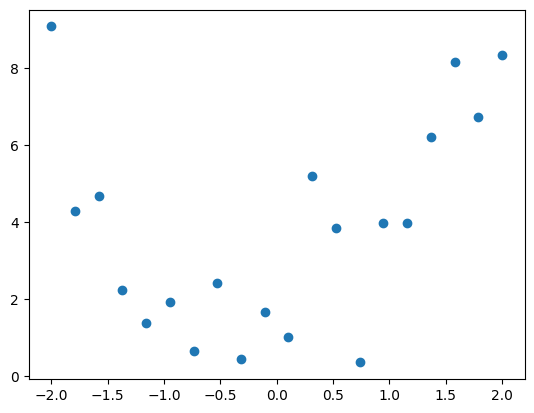

In [7]:
x = torch.linspace(-2, 2, 20)[:,None]
y = add_noise(f(x), 0.3, 1.5)
plt.scatter(x, y)

In [8]:
def mse(pred, actual): 
    return ((pred-actual)**2).mean()

In [9]:
loss = mse(f(x), y)
loss

tensor(6.0241, dtype=torch.float64)

Podemos hacer la minimización de pérdida "a mano"

In [10]:
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a,b,c):
    f=partial_quad(a,b,c)
    plt.scatter(x, y)
    plt.plot(x, f(x))
    loss = mse(f(x), y)
    plt.title(f"MSE = {loss:.2f}")

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

Podemos buscar la derivada con pytorch

In [11]:
def quad_mse(params):
    f = partial_quad(*params)
    return mse(f(x), y)

In [12]:
quad_mse([1.5,1.5,1.5])

tensor(3.0071, dtype=torch.float64)

Creamos un tensor y le pedimos que nos de la derivada

In [13]:
abc=torch.tensor([1.5,1.5,1.5])

abc.requires_grad_(True) 

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

In [14]:
loss = quad_mse(abc)
loss

tensor(3.0071, dtype=torch.float64, grad_fn=<MeanBackward0>)

loss ahora contiene el gradiente

In [15]:
loss.backward()

In [16]:
abc.grad

tensor([-0.7223,  2.3430, -0.2451])

Estas son las derivadas parciales de la funcion de pérdida en función de los cambios en los parámetros a, b y c.  
  
Como queremos minimizar la función de pérdida, queremos aumentar las variables positivas y disminuir las negativas.  
Por consiguiente, el ajuste va en dirección contraria de la derivada parcial (negativo).  
Buscando un óptimo (0, 0, 0), determinamos un step_size de 0.01.

In [17]:
with torch.no_grad(): 
    # esto hace que no calcule el gradiente del tensor durante este bloque de código
    abc = abc - abc.grad*0.01 
    loss = quad_mse(abc)

print("loss ", loss)

loss  tensor(2.9474, dtype=torch.float64)


Vemos que la función de pérdida va cayendo

In [18]:
abc.requires_grad_(True)

tensor([1.5072, 1.4766, 1.5025], requires_grad=True)

In [19]:
loss

tensor(2.9474, dtype=torch.float64)

In [20]:
for i in range(20):
    loss = quad_mse(abc.requires_grad_(True))
    loss.backward()
    with torch.no_grad():
        abc = abc - abc.grad*0.01
    print(f"Paso {i}, pérdida={loss:.2f}")

Paso 0, pérdida=2.95
Paso 1, pérdida=2.89
Paso 2, pérdida=2.84
Paso 3, pérdida=2.79
Paso 4, pérdida=2.75
Paso 5, pérdida=2.70
Paso 6, pérdida=2.66
Paso 7, pérdida=2.63
Paso 8, pérdida=2.59
Paso 9, pérdida=2.56
Paso 10, pérdida=2.53
Paso 11, pérdida=2.50
Paso 12, pérdida=2.47
Paso 13, pérdida=2.45
Paso 14, pérdida=2.42
Paso 15, pérdida=2.40
Paso 16, pérdida=2.38
Paso 17, pérdida=2.36
Paso 18, pérdida=2.34
Paso 19, pérdida=2.33


In [21]:
abc

tensor([1.5711, 1.1292, 1.5186])

# REctified Linear Units

In [23]:
def rectified_linear(m, b, x):
    y = m * x + b
    # esta es una funcion lineal
    return torch.clip(y, 0.) # clip hace que todo lo que sea negativo se haga cero

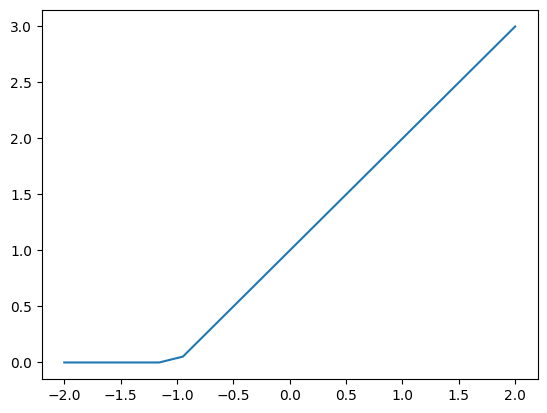

In [27]:
plt.plot(x, partial(rectified_linear, 1, 1)(x))

In [28]:
def double_relu(m1, m2, b1, b2, x):
    return rectified_linear(m1, b1, x) + rectified_linear(m2, b2, x)

In [30]:
@interact(m1=1.5, m2=1.5, b1=1.5, b2=1.5)
def plot_double_relu(m1, m2, b1, b2):
    plt.plot(x, partial(double_relu, m1, m2, b1, b2)(x))

interactive(children=(FloatSlider(value=1.5, description='m1', max=4.5, min=-1.5), FloatSlider(value=1.5, desc…

Podemos agregar una cantidad arbitraria de relus, lo cual permite aproximar arbitrariamente funciones.  
ADD MORE LAYERS

# Con multiplicacion matricial
Podemos simplificar el cálculo de las ReLus usando multiplicacion matricial.  
El cálculo es $X *  \beta =  \Epsilon$  
donde X son los datos, $ \beta$ los coeficientes,  
y luego se rectifica $ \Epsilon$ usando la función $min(\epsilon_{ij}, 0)$

In [196]:
n_relus=5
params_by_relu = 2

Cada relu tiene dos parametros, m y b

In [198]:
beta = np.random.rand(n_relus, params_by_relu) - 0.5
# inicializo random cerca de cero
beta = torch.from_numpy(beta)
beta = beta.to(torch.float32)
beta

tensor([[ 0.4415, -0.1139],
        [ 0.4612,  0.4054],
        [-0.3042, -0.4306],
        [-0.3992, -0.4818],
        [-0.4056,  0.1830]])

Para que esto funcione, tenemos que ponerle una columna de 1s a la x, que son la multiplicacion de la constante

In [199]:
ones = torch.ones(x.shape[0], 1)
X = torch.cat((x, ones), dim=1)
X[:5]

tensor([[-2.0000,  1.0000],
        [-1.7895,  1.0000],
        [-1.5789,  1.0000],
        [-1.3684,  1.0000],
        [-1.1579,  1.0000]])

In [200]:
E = torch.matmul(X, beta.T)
E[:5]

tensor([[-0.9968, -0.5170,  0.1778,  0.3167,  0.9941],
        [-0.9039, -0.4199,  0.1137,  0.2326,  0.9087],
        [-0.8109, -0.3228,  0.0497,  0.1486,  0.8234],
        [-0.7180, -0.2258, -0.0144,  0.0645,  0.7380],
        [-0.6251, -0.1287, -0.0784, -0.0195,  0.6526]])

Estos son los resultados de las linear units (sin rectificar)

In [201]:
E_r = torch.clip(E, 0)
E_r[:5]

tensor([[0.0000, 0.0000, 0.1778, 0.3167, 0.9941],
        [0.0000, 0.0000, 0.1137, 0.2326, 0.9087],
        [0.0000, 0.0000, 0.0497, 0.1486, 0.8234],
        [0.0000, 0.0000, 0.0000, 0.0645, 0.7380],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6526]])

ahi estan rectificados.  

Para obtener el valor del $\hat{y}$ hay que sumar across

In [202]:
Y_hat = torch.sum(E_r, dim=1)
Y_hat[:5]

tensor([1.4886, 1.2551, 1.0216, 0.8025, 0.6526])

A esto le podemos calcular un mse.

In [203]:
mse(actual=y, pred=Y_hat)

tensor(15.2711, dtype=torch.float64)

In [204]:
beta.requires_grad_(True)
beta

tensor([[ 0.4415, -0.1139],
        [ 0.4612,  0.4054],
        [-0.3042, -0.4306],
        [-0.3992, -0.4818],
        [-0.4056,  0.1830]], requires_grad=True)

En un loop de optimizacion:

In [214]:
beta = np.random.rand(n_relus, params_by_relu) - 0.5
# inicializo random cerca de cero
beta = torch.from_numpy(beta)
beta = beta.to(torch.float32)

In [216]:
for i in range(1,51):
    beta.requires_grad_(True)

    E = torch.matmul(X, beta.T)
    E_r = torch.clip(E, 0)
    Y_hat = torch.sum(E_r, dim=1)

    loss = mse(pred=Y_hat, actual=y)
    
    loss.backward(retain_graph=True)

    with torch.no_grad():
        beta = beta - beta.grad*0.01

    if i%5==0:
        print(f"Paso {i}, pérdida={loss:.2f}")

Paso 5, pérdida=7.53
Paso 10, pérdida=7.51
Paso 15, pérdida=7.49
Paso 20, pérdida=7.47
Paso 25, pérdida=7.45
Paso 30, pérdida=7.43
Paso 35, pérdida=7.42
Paso 40, pérdida=7.40
Paso 45, pérdida=7.39
Paso 50, pérdida=7.38


# TODO:
Me quedó peor MSE y peor gráfico que en la def quadratic. What?

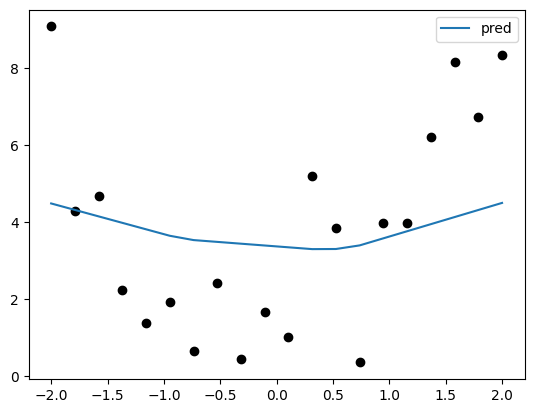

In [218]:
plt.plot(x, Y_hat.detach(), label='pred')
plt.scatter(x, y, c='black')
plt.legend()